In [8]:
# 라이브러리 설치 및 임포트
!pip install transformers datasets sacrebleu evaluate accelerate -q

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback

# 재현성을 위한 시드 고정
SEED = 42
torch.manual_seed(SEED)

In [13]:
# 데이터 로드 및 전처리
df = pd.read_csv('data.csv')

df['input_text'] = df['intent']
df['target_text'] = df['my_trans']

# 데이터 분할
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

print(f"Data Splits - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Data Splits - Train: 80, Val: 10, Test: 10


In [14]:
# 모델 로드
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [15]:
# 토크나이징 함수 정의
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    inputs = examples["input_text"]
    targets = examples["target_text"]

    # 입력(한국어) 토크나이징
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # 출력(영어) 토크나이징
    labels = tokenizer(text_target=targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [16]:
# 학습 설정
batch_size = 16
args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=50,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True, # GPU 가속
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [17]:
# 학습 시작
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

print("Training Started...")
trainer.train()

/tmp/ipython-input-298457884.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Training Started...


Epoch,Training Loss,Validation Loss
1,No log,2.221231
2,2.557900,1.787793
3,2.557900,1.545715
4,1.555000,1.404609
5,1.555000,1.290078
6,1.035500,1.211717
7,1.035500,1.176264
8,0.736600,1.156318
9,0.736600,1.129627
10,0.534400,1.103595


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,2.221231
2,2.557900,1.787793
3,2.557900,1.545715
4,1.555000,1.404609
5,1.555000,1.290078
6,1.035500,1.211717
7,1.035500,1.176264
8,0.736600,1.156318
9,0.736600,1.129627
10,0.534400,1.103595


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=125, training_loss=0.6288636655807495, metrics={'train_runtime': 1175.965, 'train_samples_per_second': 3.401, 'train_steps_per_second': 0.213, 'total_flos': 12855954898944.0, 'train_loss': 0.6288636655807495, 'epoch': 25.0})

In [18]:
# 모델 저장
save_path = "./my_style_transfer_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model saved to {save_path}")

Model saved to ./my_style_transfer_model


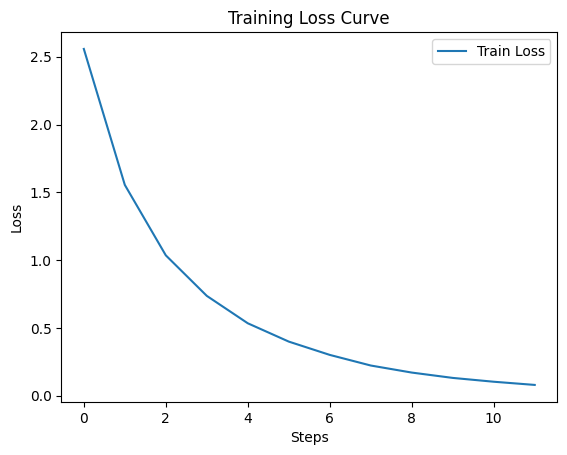

In [19]:
# 학습 곡선 시각화
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# 허깅페이스 허브 로그인
from huggingface_hub import notebook_login

notebook_login()

In [20]:
# 모델 업로드
repo_name = "cai-translator"

model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print("업로드 완료")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...6q6o4iw/model.safetensors:   0%|          |  229kB /  310MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  /tmp/tmpd1vf9110/target.spm : 100%|##########|  813kB /  813kB            

  /tmp/tmpd1vf9110/source.spm : 100%|##########|  842kB /  842kB            

업로드 완료
